In [155]:
import torch
import matplotlib.pyplot as plt
try:
    import qvarnet
    from qvarnet.models.mlp import MLP
except ImportError:
    print("If variational approach, please install qvarnet.")

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

### Parameters

In [156]:
# PARAMETERS
HBAR = 1.0
MASS = 1.0
V0 = 10.0
K1 = 1.0
PBC = True

N_POINTS = 1_000
N_PERIODS_FROM_CENTRE_TO_RIGHT = 0.5 # number of periods from the center to the right edge
A = N_PERIODS_FROM_CENTRE_TO_RIGHT
L_BOX = 2*torch.pi/K1 * A
GRID_SPACING = L_BOX / N_POINTS

### Exact diagonalization utils

#### Potential definition

In [157]:
def V(x,V0,K1):
    """Potential function."""
    return V0 * torch.sin(K1 * x).pow(2)

##### Potential drawing

''

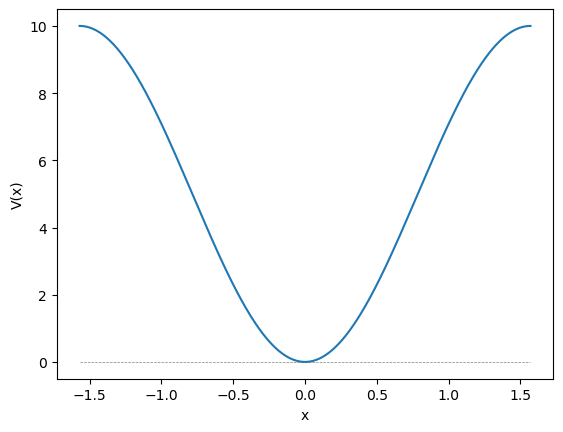

In [158]:
x_pot = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)

plt.hlines(0, -L_BOX/2, L_BOX/2, colors='gray', linestyles='dashed', linewidths=0.5)
plt.plot(x_pot.cpu().numpy(), V(x_pot,V0,K1).cpu().numpy(), label='Potential V(x)')
plt.xlabel('x')
plt.ylabel('V(x)')
;

#### Hamiltonian definition

In [159]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, potential_parameters, x):
    kin_coeff = -HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = -2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = 1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = V(x[i],**potential_parameters)
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

##### Local energy checking

Number of points in the grid: 1000
Box length: 3.141592653589793
torch.Size([1000, 1000])
Eigenvalue 0: 2.1019401993370077
Eigenvalue 1: 6.054777941712993
Eigenvalue 2: 8.730739279538932
Eigenvalue 3: 13.330196204644155
Eigenvalue 4: 13.552570852569584


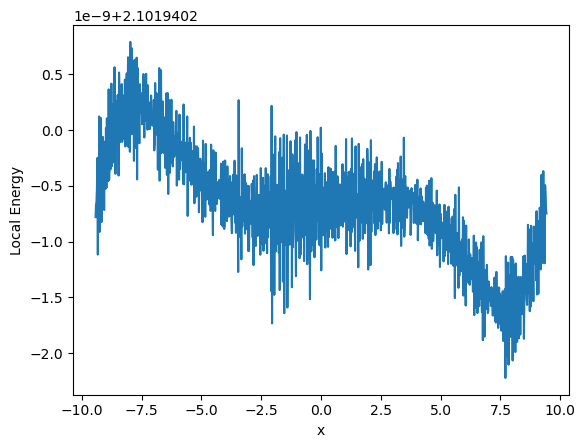

In [160]:
H = hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, {'V0': V0, 'K1': K1}, x_pot)
eigenvalues, eigenstates = torch.linalg.eigh(H)
print(f"Number of points in the grid: {N_POINTS}")
print(f"Box length: {L_BOX}")
print(eigenstates.shape)

for i in range(5):
    print(f'Eigenvalue {i}: {eigenvalues[i].item()}')

# check local energy
local_energy = H@eigenstates[:, 0] / eigenstates[:, 0]
plt.plot(x.cpu().numpy(), local_energy.cpu().numpy(), label='Local Energy')
plt.xlabel('x')
plt.ylabel('Local Energy');

In [161]:
def plot_wf_with_PBC(wavefunction):
    for shift in [-L_BOX, 0, L_BOX]:
        plt.plot(x.cpu().numpy() + shift, wavefunction**2, alpha=0.5)
        # plt.plot(x.cpu().numpy() + shift, V(x).cpu().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=0.5, linewidth=0.5)
    plt.xlim(-L_BOX, L_BOX)
    plt.vlines([-L_BOX/2, L_BOX/2], 0, V0, colors='red', linestyles='dashed', alpha=0.5, linewidth=0.5) 

### Variational utils

In [162]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

def numerical_kin_energy(psi):
    # Compute kin energy with 2 point central differences
    d2psi = torch.zeros_like(psi)
    psi_extended_pbc = torch.zeros((psi.shape[0] + 2,), device=psi.device)
    # psi_extended_pbc = torch.cat((psi[-1], psi, psi[0]))  # Extend for PBC
    d2psi = (psi_extended_pbc[:-2] - 2*psi_extended_pbc[1:-1] + psi_extended_pbc[2:]) / (GRID_SPACING**2)
    kin_energy = -0.5 * d2psi
    return kin_energy

# Computation

## Exact diagonalization

In [163]:
x_train = torch.linspace(-L_BOX/2, L_BOX/2, N_POINTS).view(-1, 1).to(device)
x_train.requires_grad = True

Energy of the ground state: 2.1019401993370077


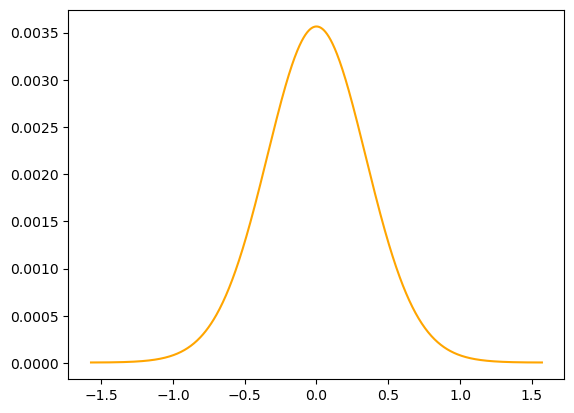

In [164]:
ed_eigvals, ed_eigstates = torch.linalg.eigh(hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, {'V0': V0, 'K1': K1}, x_train))

print(f"Energy of the ground state: {ed_eigvals[0].item()}")
plt.plot(x_train.detach().cpu().numpy(), ed_eigstates[:, 0].detach().cpu().numpy()**2, label='Exact Ground State', color='orange')

In [165]:
# Variational parameters
epochs = 10_000
Nh=100
NLayers = 1
lr = 0.001
activation_function = "tanh"

energy_history = []
wf_history = []

In [ ]:
layer_dims = [1] + [Nh] * NLayers + [1]

model = MLP(layer_dims=layer_dims, activation=activation_function)
model.to(device)

# init weights
for param in model.parameters():
    if len(param.shape) > 1:  # only initialize weights, not biases
        torch.nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

callback = EarlyStoppingCallback(patience=500, min_delta=1e-4)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = numerical_kin_energy(psi).view(-1, 1)  # compute kinetic energy
    V_psi = V(x_train,V0,K1) * psi
    H_psi = T + V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy

    energy_history.append(energy.item())
    wf_history.append(psi.clone())

    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    loss += 1e-1 * (norm_psi - 1)**2  # enforce normalization condition
    psi = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    loss += 1e0 * (psi[0] - psi[-1])**2 # penalize boundary conditions
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}")

    if callback is not None:
        callback(epoch, loss, model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
# print(energy)
# model.load_state_dict(callback.best_model_state)

Epoch 1/10000, Loss: 6.3755, Energy: 6.3073
Epoch 101/10000, Loss: 2.6205, Energy: 2.5216
Epoch 201/10000, Loss: 2.2471, Energy: 2.1494
Epoch 301/10000, Loss: 2.2427, Energy: 2.1451
Epoch 401/10000, Loss: 2.2365, Energy: 2.1389
Epoch 501/10000, Loss: 2.2275, Energy: 2.1301
Epoch 601/10000, Loss: 2.2143, Energy: 2.1169
Epoch 701/10000, Loss: 2.1932, Energy: 2.0958
Epoch 801/10000, Loss: 2.1544, Energy: 2.0567
Epoch 901/10000, Loss: 2.0328, Energy: 1.9340
Epoch 1001/10000, Loss: 4.1836, Energy: 4.1761
Epoch 1101/10000, Loss: 2.0468, Energy: 1.9545
Epoch 1201/10000, Loss: 2.0107, Energy: 1.9183
Epoch 1301/10000, Loss: 1.9596, Energy: 1.8667
Epoch 1401/10000, Loss: 1.8761, Energy: 1.7824
Epoch 1501/10000, Loss: 1.7007, Energy: 1.6051
Epoch 1601/10000, Loss: 4.5700, Energy: 4.5001
Epoch 1701/10000, Loss: 3.1107, Energy: 3.0490
Epoch 1801/10000, Loss: 1.2869, Energy: 1.1930
Epoch 1901/10000, Loss: 0.8711, Energy: 0.7727
Epoch 2001/10000, Loss: 0.8361, Energy: 0.7378
Epoch 2101/10000, Loss: 0

### Plotting ED vs Variational

In [178]:
ed_ground_state = ed_eigstates[:, 0].view(-1, 1)

Norm of wavefunction: 0.9999987278532715
shape of ed_eigstates: torch.Size([1000, 1000])
shape of norm_other: torch.Size([1])
type of norm_other: <class 'torch.Tensor'>
Norm of eigenstate: 0.0031447248082045907
New norm of eigenstate: 0.9999968200816252
......................
Energy from ED: 2.1019401993370077
Energy from VMC: 0.09003100434301899


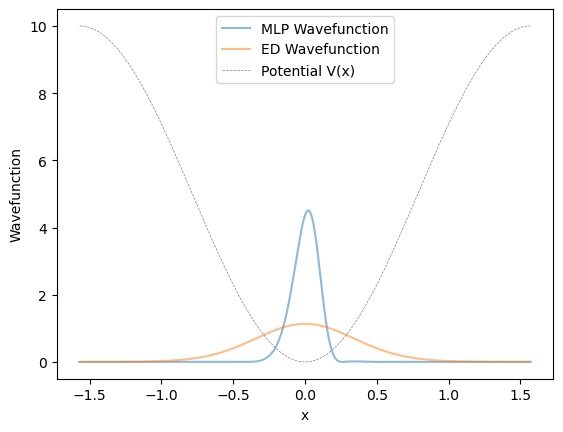

In [179]:
plt.plot(x_train.cpu().detach().numpy(), psi.detach().cpu().numpy()**2, label='MLP Wavefunction', alpha=0.5)
norm = torch.trapezoid(psi.pow(2), x_train, dim=0)
print(f'Norm of wavefunction: {norm.item()}')
print(f"shape of ed_eigstates: {ed_eigstates.shape}")
norm_other = torch.trapezoid(ed_ground_state.pow(2), x_train, dim=0)
print(f"shape of norm_other: {norm_other.shape}")
print(f"type of norm_other: {type(norm_other)}")
print(f'Norm of eigenstate: {norm_other.item()}')
psi_ed = ed_ground_state.clone().detach()/ torch.sqrt(norm_other + 1e-8)  # normalize eigenstate
new_norm = torch.trapezoid(psi_ed.pow(2), x_train, dim=0)
print(f'New norm of eigenstate: {new_norm.item()}')
plt.plot(x_train.detach().cpu().numpy(), psi_ed.cpu().detach().numpy()**2, label='ED Wavefunction', alpha=0.5)
plt.plot(x_train.cpu().detach().numpy(), V(x_train,V0,K1).cpu().detach().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=1, linewidth=0.5)

print("......................")
print(f'Energy from ED: {ed_eigvals[0].item()}')
print(f'Energy from VMC: {energy_copy.item()}')
plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.legend();

In [169]:
for idx, energy in enumerate(energy_history):
    if energy<0.0:
        # reset gradient in wf_hist
        wf_history[idx] = wf_history[idx].clone()
        plt.plot(x_train.detach().cpu().numpy(), wf_history[idx].detach().cpu().numpy()**2, label=f'VMC Wavefunction Epoch {idx}', alpha=0.5)
        # compute the energy again
        T = numerical_kin_energy(wf_history[idx]).view(-1, 1)
        V_psi = V(x_train,V0,K1) * wf_history[idx]
        H_psi = T + V_psi
        numerator = torch.trapezoid(torch.conj(wf_history[idx]) * H_psi, x_train, dim=0)
        print(T.shape)
        print(V_psi.shape)
        denominator = torch.trapezoid(wf_history[idx].pow(2), x_train, dim=0)
        energy = numerator / denominator
        print(f"Epoch {idx}, Energy: {energy.item():.4f}")

In [184]:
# compute the energy of the ed with the variational method:
psi_ed = ed_eigstates[:, 0].clone().detach().cpu().to(device).view(-1, 1)  # ensure it is a column vector
T = numerical_kin_energy(psi_ed).view(-1, 1)
V_psi = V(x_train,V0,K1) * psi_ed
H_psi = T + V_psi
numerator = torch.trapezoid(torch.conj(psi_ed) * H_psi, x_train, dim=0)
denominator = torch.trapezoid(psi_ed.pow(2), x_train, dim=0)
energy_ed = numerator / denominator
print(f"Energy of the ED wavefunction: {energy_ed.item():.4f}")

Energy of the ED wavefunction: 1.1337
